# 14: Ethical reflections on data science

The hand-in exercise for this topic is Exercise 1 from the notebook “Exercises in Fairness in Machine Learning.ipynb”.

In [127]:
# Imports:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Exercise 1

For this exercise, we will use the `adult` dataset (available on moodle or from the [UCI Machine Learning repository](https://archive.ics.uci.edu/dataset/2/adult)). Do the following:

1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).
2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)
3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)
4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.
5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.
6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.
7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)
8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.
9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)
10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?
11. Is there predictive parity across different genders?
12. Is there Statistical parity across different genders?
13. [Discussion question] Can your any of your models be used to make fair salary predictions?
14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
15. [Discussion question] If the dataset is biased, where could the bias potentially come from?
16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?

### 1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).

In [128]:
df = pd.read_csv('adult.csv')
df['income'] = df['income'].str.strip(".")
df['income'].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

### 2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)

In [129]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [130]:
features = ['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'hours-per-week']
X = df[features]
X.isna().sum()

age                 0
workclass         963
education           0
occupation        966
race                0
sex                 0
hours-per-week      0
dtype: int64

There is some missing values, fill those categorical features in with "unknown" where missing values are found

In [131]:
X = X.fillna('Unknown')
X.isna().sum()

age               0
workclass         0
education         0
occupation        0
race              0
sex               0
hours-per-week    0
dtype: int64

### 3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)

In [132]:
X = pd.get_dummies(X, columns=['workclass', 'education', 'occupation', 'race', 'sex'], drop_first=True)
X.head()

,age,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,39,40,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,True
1,50,13,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,True
2,38,40,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
3,53,40,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,28,40,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


### 4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.

In [133]:
y = df['income']
y = y.map({'<=50K': 0, '>50K': 1})

### 5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
#TRain the model
model = XGBClassifier()
model.fit(X_train, y_train)
#Make predictions
y_pred = model.predict(X_test)

### 6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.

In [135]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
# Now to look at the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Model accuracy: 0.8202415887531563
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     11166
           1       0.68      0.47      0.55      3487

    accuracy                           0.82     14653
   macro avg       0.76      0.70      0.72     14653
weighted avg       0.81      0.82      0.81     14653

Confusion Matrix:
[[10377   789]
 [ 1845  1642]]


### 7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.) 

In [136]:
# Create sepparate test sets for both genders
X_test_female = X_test[X_test["sex_Male"] == 0]
X_test_male = X_test[X_test["sex_Male"] == 1]
y_test_female = y_test[X_test["sex_Male"] == 0]
y_test_male = y_test[X_test["sex_Male"] == 1]
# Created pred for both genders
y_pred_female = model.predict(X_test_female)
y_pred_male = model.predict(X_test_male)
# Lastlsy create a confusion matrix for each!
conf_matrix_female = confusion_matrix(y_test_female, y_pred_female)
conf_matrix_male = confusion_matrix(y_test_male, y_pred_male)
# print female confusion matrix
print('Female-Confusion-Matrix')
print(conf_matrix_female)
# print male vesrion
print('Male-Confusion-Matrix')
print(conf_matrix_male)

Female-Confusion-Matrix
[[4302   68]
 [ 425   59]]
Male-Confusion-Matrix
[[6075  721]
 [1420 1583]]


To enhance readability the matrixes will be plotted:

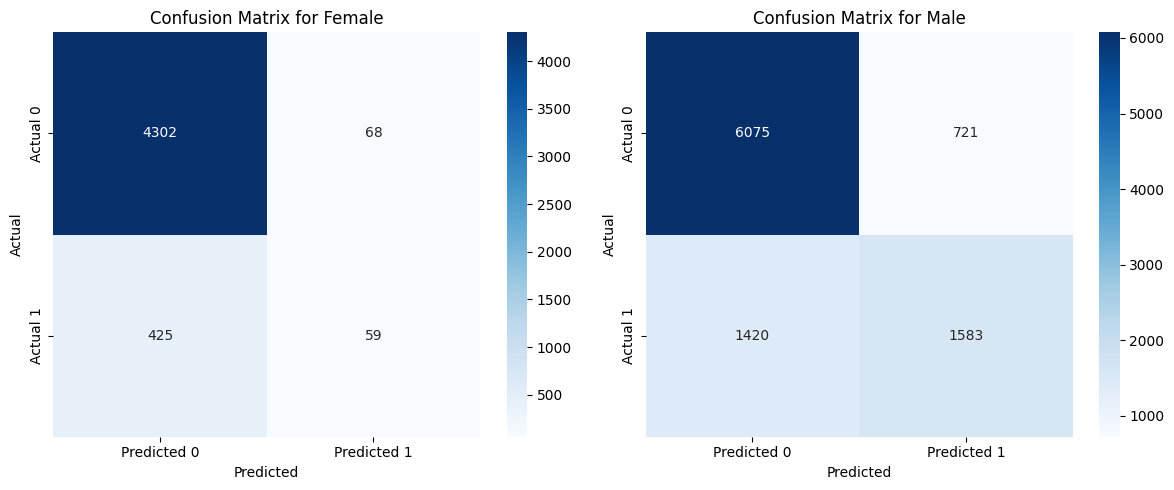

In [137]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_female, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Female')
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_male, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Male')
plt.tight_layout()
plt.show()

### 8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.

In [138]:
# SOme different performance metrics for female + male, including accuracy
print(classification_report(y_test_female, y_pred_female))
print(classification_report(y_test_male, y_pred_male))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      4370
           1       0.46      0.12      0.19       484

    accuracy                           0.90      4854
   macro avg       0.69      0.55      0.57      4854
weighted avg       0.87      0.90      0.87      4854

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      6796
           1       0.69      0.53      0.60      3003

    accuracy                           0.78      9799
   macro avg       0.75      0.71      0.72      9799
weighted avg       0.77      0.78      0.77      9799



#### The accuracy of the xgBoost on the female grp was 90% and on the male grp 78%
This indicates that with the xgBoost females income category is easier to predict, what could the reason for this be?
* The reason for this could be a certain class dominates the female half of the data, indicating that most females fall under one of the two categories (>50k, <=50k)
* Sample size, since there seem to be way more males than females in the dataset

### 9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)

In [139]:
# Calculate the TP and NP by extracting the values from the confusion matrix
# Extract TP, TN, FP, FN for females
TN_f, FP_f, FN_f, TP_f = conf_matrix_female.ravel()
# Extract TP, TN, FP, FN for males
TN_m, FP_m, FN_m, TP_m = conf_matrix_male.ravel()
# Print the values
print(f'FEMALE: TP_f: {TP_f}, TN_f: {TN_f}, FP_f: {FP_f}, FN_f: {FN_f}')
print(f'MALES: TP_m: {TP_m}, TN_m: {TN_m}, FP_m: {FP_m}, FN_m: {FN_m}')

FEMALE: TP_f: 59, TN_f: 4302, FP_f: 68, FN_f: 425
MALES: TP_m: 1583, TN_m: 6075, FP_m: 721, FN_m: 1420


### 10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?

##### **False Positive Rate (FPR):**
* Females: 1.56%
* Males: 10.61%
##### **False Negative Rate (FNR):**
* Females: 87.81%
* Males: 47.29%

Why is the false positive rate much higher for males than females?
* More males in the dataset making the model more likely to misclassify due to imbalance in the data
* Distribution of the categorical values 'income', there are generally more males making >50k, making the model more likely to classify males under that category
* Same goes for women, if more women are urning <=50k
* If the dataset is old, it might be bias by the histroy of women making less money than men on avg

### 11. Is there predictive parity across different genders?

To answer this we are gonna start by calculating the  predicitve parity precision

In [140]:
# Compute Precision (PPP) for females and males
PPV_f = TP_f / (TP_f + FP_f)
PPV_m = TP_m / (TP_m + FP_m)

# Display results
print(f"Precision (PPV) for Females: {PPV_f:.4f}")
print(f"Precision (PPV) for Males: {PPV_m:.4f}")


Precision (PPV) for Females: 0.4646
Precision (PPV) for Males: 0.6871


So is there predictive parity across different genders?

* By definition the ciretrias are only met for this when the predictive parity precission is equal across groups
* With the precision for Females being 46.46% & for Males 68.71%
* This means the hypotheses fails

### 12. Is there Statistical parity across different genders?

To do this we need to compute the statistical selection rate (SR) for Females and Males

In [141]:
# Compute Selection Rate (SR) for females and males
SR_f = (TP_f + FP_f) / (TP_f + FP_f + TN_f + FN_f)
SR_m = (TP_m + FP_m) / (TP_m + FP_m + TN_m + FN_m)

# Display results
print(f"Selection Rate (SR) for Females: {SR_f:.4f}")
print(f"Selection Rate (SR) for Males: {SR_m:.4f}")


Selection Rate (SR) for Females: 0.0262
Selection Rate (SR) for Males: 0.2351


* (SR) for Females: 0.0262
* (SR) for Males: 0.2351
* This means the Statistical parity fails, since the two values differ too much

### 13. [Discussion question] In what sense is the `adult` dataset biased (unfair)? + 14. [Discussion question] If the dataset is biased, where could the bias potentially come from?

The dataset is biased/unfair based on:

* Looking at the soruce kaggle page linked at the top of this notebook the dataset originates from 1990s
* In this time period there were trends of women earning less then men on avg
* Furthermore the data might also have a racial BIAS, as people of certain races might be less favored in the job market
* Imbalance in representation of the two genders, men are better represented than women in this case